In [14]:
from __future__ import print_function

import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

working_path = "../outs/"

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code

img_rows = 512
img_cols = 512

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet():
    inputs = Input((1,img_rows, img_cols))
    #conv1 = Convolution2D(1, 1, 1, activation="sigmoid", border_mode="same")
    conv1 = Conv2D(1, (1, 1), activation="sigmoid", padding="same")(inputs)

    model = Model(input=inputs, output=conv1)

    model.compile(optimizer=Adam(lr=1.0e-1), loss=dice_coef_loss, metrics=[dice_coef])

    return model


In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12820591969666699090
]


In [16]:
import matplotlib.pyplot as plt

def make_blob_mask(width, height, x, y, s, t):
    xx = np.arange(width)
    yy = np.arange(height)
    xxx, yyy = np.meshgrid(xx, yy)
    
    z = np.exp(-0.5*((xxx-x)**2 + (yyy-y)**2)/(s**2))
    
    m = (z>t)
    
    return z, m
    
    

<IPython.core.display.Javascript object>


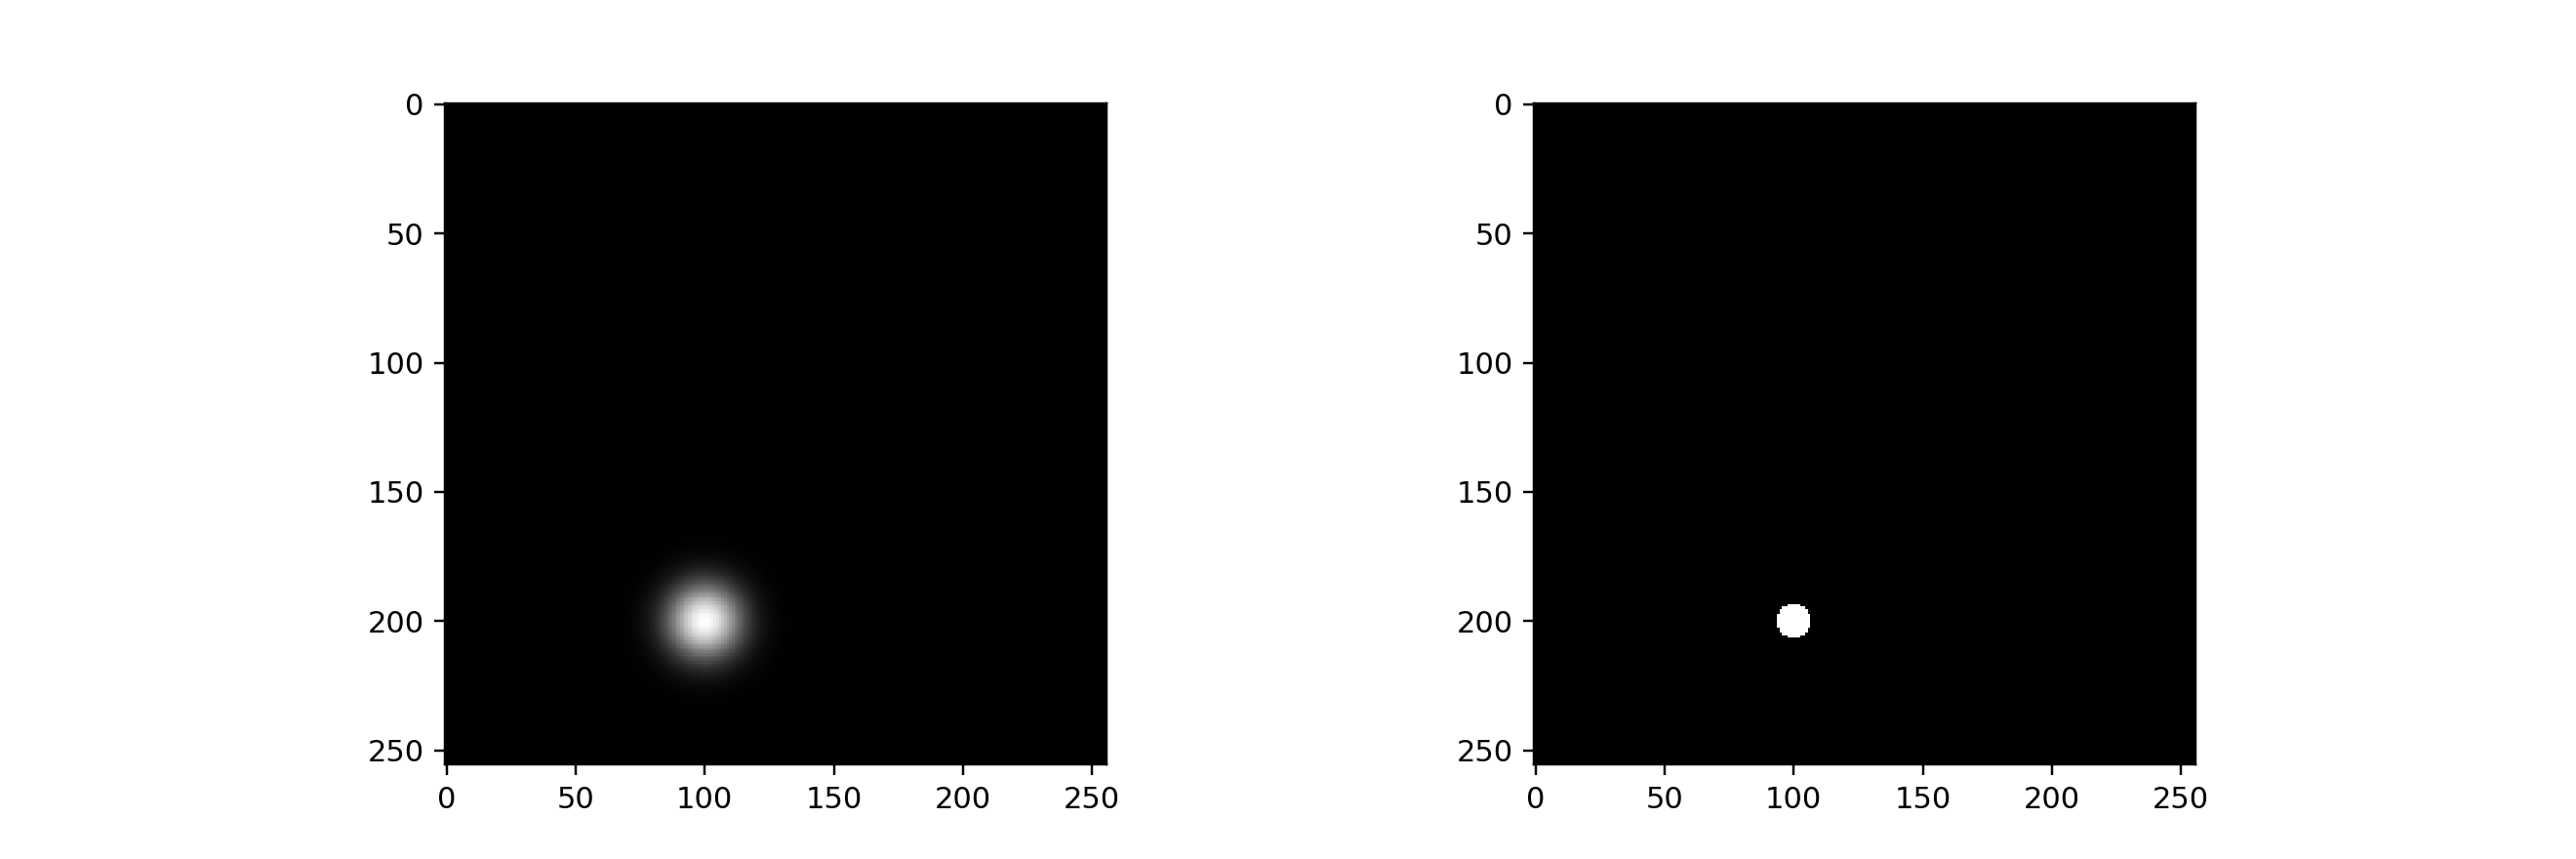

(256, 256)

In [17]:
img_test, img_mask = make_blob_mask(256,256,100,200,10, 0.8)

fig,ax = plt.subplots(1,2,figsize=[12,4])
ax[0].imshow(img_test,cmap='gray')        
ax[1].imshow(img_mask,cmap='gray')
            
plt.show()
img_test.shape

In [18]:
import random

num_images = 100


final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)

for i in range(num_images):
    img_test, img_mask = make_blob_mask(512,512,random.randrange(10,502),random.randrange(10,502),10, 0.8)
    
    final_images[i,0] = img_test
    final_masks[i,0] = img_mask
    

final_images.shape


rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(working_path+"fake_trainImages.npy",final_images[rand_i[test_i:]])
np.save(working_path+"fake_trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(working_path+"fake_testImages.npy",final_images[rand_i[:test_i]])
np.save(working_path+"fake_testMasks.npy",final_masks[rand_i[:test_i]])

    
    

In [25]:
print('-'*30)
print('Loading and preprocessing train data...')
print('-'*30)

imgs_train = np.load(working_path+"fake_trainImages.npy").astype(np.float32)
imgs_mask_train = np.load(working_path+"fake_trainMasks.npy").astype(np.float32)

imgs_test = np.load(working_path+"fake_testImages.npy").astype(np.float32)
imgs_mask_test_true = np.load(working_path+"fake_testMasks.npy").astype(np.float32)

'''mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean  # images should already be standardized, but just in case
imgs_train /= std'''

print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model = get_unet()
# Saving weights to unet.hdf5 at checkpoints
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)
#
# Should we load existing weights? 
# Set argument for call to train_and_predict to true at end of script
use_existing = False

if use_existing:
    model.load_weights('./unet.hdf5')

# 
# The final results for this tutorial were produced using a multi-GPU
# machine using TitanX's.
# For a home GPU computation benchmark, on my home set up with a GTX970 
# I was able to run 20 epochs with a training set size of 320 and 
# batch size of 2 in about an hour. I started getting reseasonable masks 
# after about 3 hours of training. 
#
print('-'*30)
print('Fitting model...')
print('-'*30)

#model.set_weights([np.array([[[[100]]]], dtype=np.float32), np.array([-80], dtype=np.float32)])
model.fit(imgs_train, imgs_mask_train, batch_size=10, epochs=100, verbose=1, shuffle=True,
          callbacks=[model_checkpoint])

# loading best weights from training session
print('-'*30)
print('Loading saved weights...')
print('-'*30)
model.load_weights('./unet.hdf5')

print('-'*30)
print('Predicting masks on test data...')
print('-'*30)
num_test = len(imgs_test)
imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
for i in range(num_test):
    imgs_mask_test[i] = model.predict([imgs_test[i:i+1]], verbose=0)[0]
np.save('masksTestPredicted.npy', imgs_mask_test)
mean = 0.0
for i in range(num_test):
    mean+=dice_coef_np(imgs_mask_test_true[i,0], imgs_mask_test[i,0])
mean/=num_test
print("Mean Dice Coeff : ",mean)

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------


/home/lucas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/100
80/80 [==============================] - 0s 6ms/step - loss: -0.0019 - dice_coef: 0.0019
Epoch 2/100
80/80 [==============================] - 1s 7ms/step - loss: -0.0033 - dice_coef: 0.0033
Epoch 3/100
80/80 [==============================] - 0s 6ms/step - loss: -0.0068 - dice_coef: 0.0068
Epoch 4/100
80/80 [==============================] - 0s 5ms/step - loss: -0.0159 - dice_coef: 0.0159
Epoch 5/100
80/80 [==============================] - 0s 5ms/step - loss: -0.0413 - dice_coef: 0.0413
Epoch 6/100
80/80 [==============================] - 0s 5ms/step - loss: -0.1091 - dice_coef: 0.1091
Epoch 7/100
80/80 [==============================] - 0s 5ms/step - loss: -0.2526 - dice_coef: 0.2526
Epoch 8/100
80/80 [==============================] - 0s 4ms/step - loss: -0.4353 - dice_coef: 0.4353
Epoch 9/100
80/80 [==============================] - 0s 4ms/step - loss: -0.5692 - dice_coef: 0.5692
Epoch 10/100
80/80 [==============================] - 0s 5ms/step - loss: -0.6450 - dice_co

80/80 [==============================] - 0s 6ms/step - loss: -0.8639 - dice_coef: 0.8639
Epoch 82/100
80/80 [==============================] - 1s 8ms/step - loss: -0.8647 - dice_coef: 0.8647
Epoch 83/100
80/80 [==============================] - 1s 8ms/step - loss: -0.8655 - dice_coef: 0.8655
Epoch 84/100
80/80 [==============================] - 1s 7ms/step - loss: -0.8663 - dice_coef: 0.8663
Epoch 85/100
80/80 [==============================] - 0s 5ms/step - loss: -0.8671 - dice_coef: 0.8671
Epoch 86/100
80/80 [==============================] - 0s 3ms/step - loss: -0.8679 - dice_coef: 0.8679
Epoch 87/100
80/80 [==============================] - 1s 7ms/step - loss: -0.8687 - dice_coef: 0.8687
Epoch 88/100
80/80 [==============================] - 1s 6ms/step - loss: -0.8694 - dice_coef: 0.8694
Epoch 89/100
80/80 [==============================] - 0s 3ms/step - loss: -0.8702 - dice_coef: 0.8702
Epoch 90/100
80/80 [==============================] - 0s 3ms/step - loss: -0.8709 - dice_coef: 

In [23]:
model.get_weights()

[array([[[[17.530481]]]], dtype=float32), array([-13.840859], dtype=float32)]

image 0


<IPython.core.display.Javascript object>


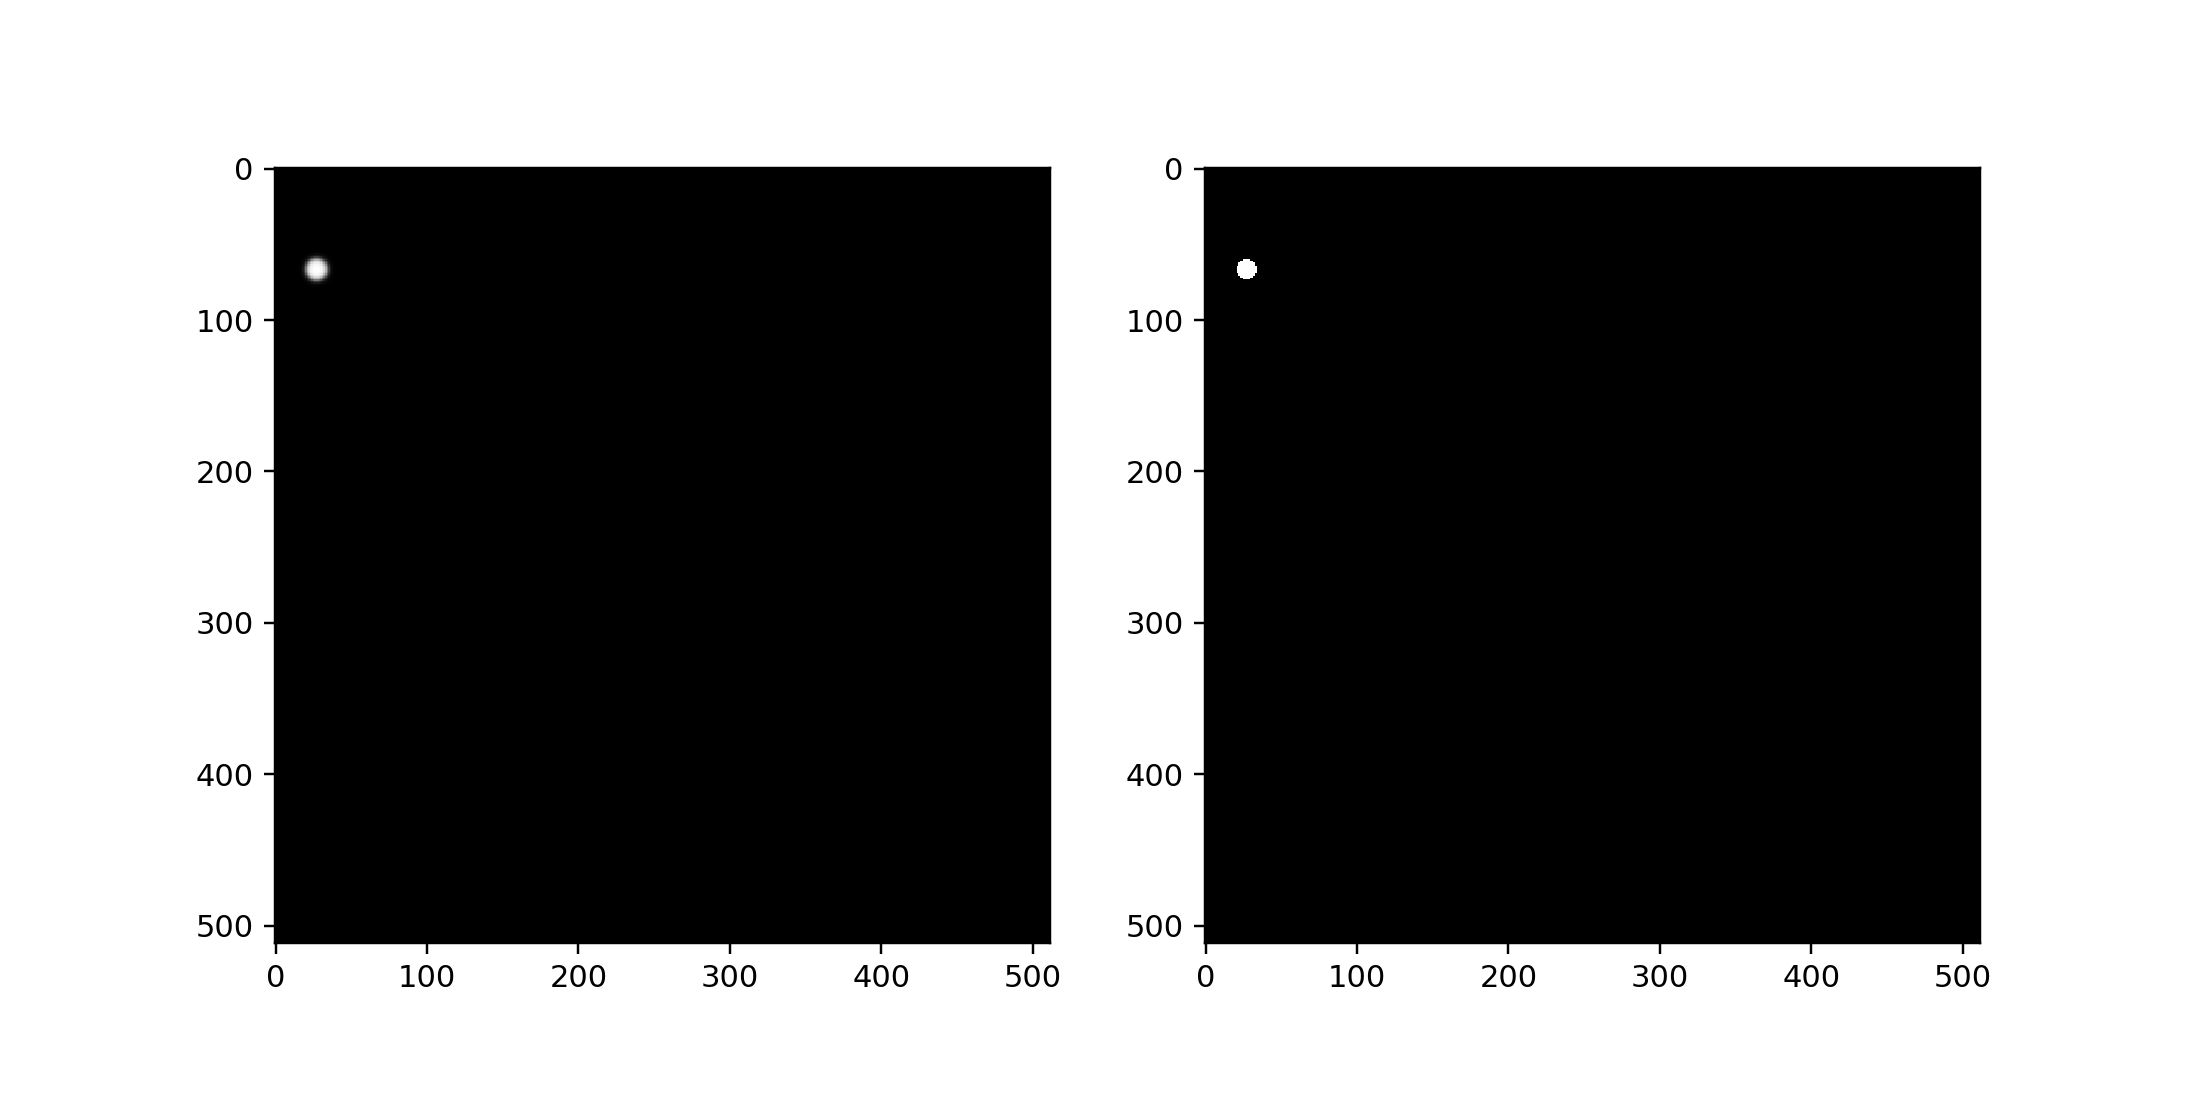

image 1


<IPython.core.display.Javascript object>


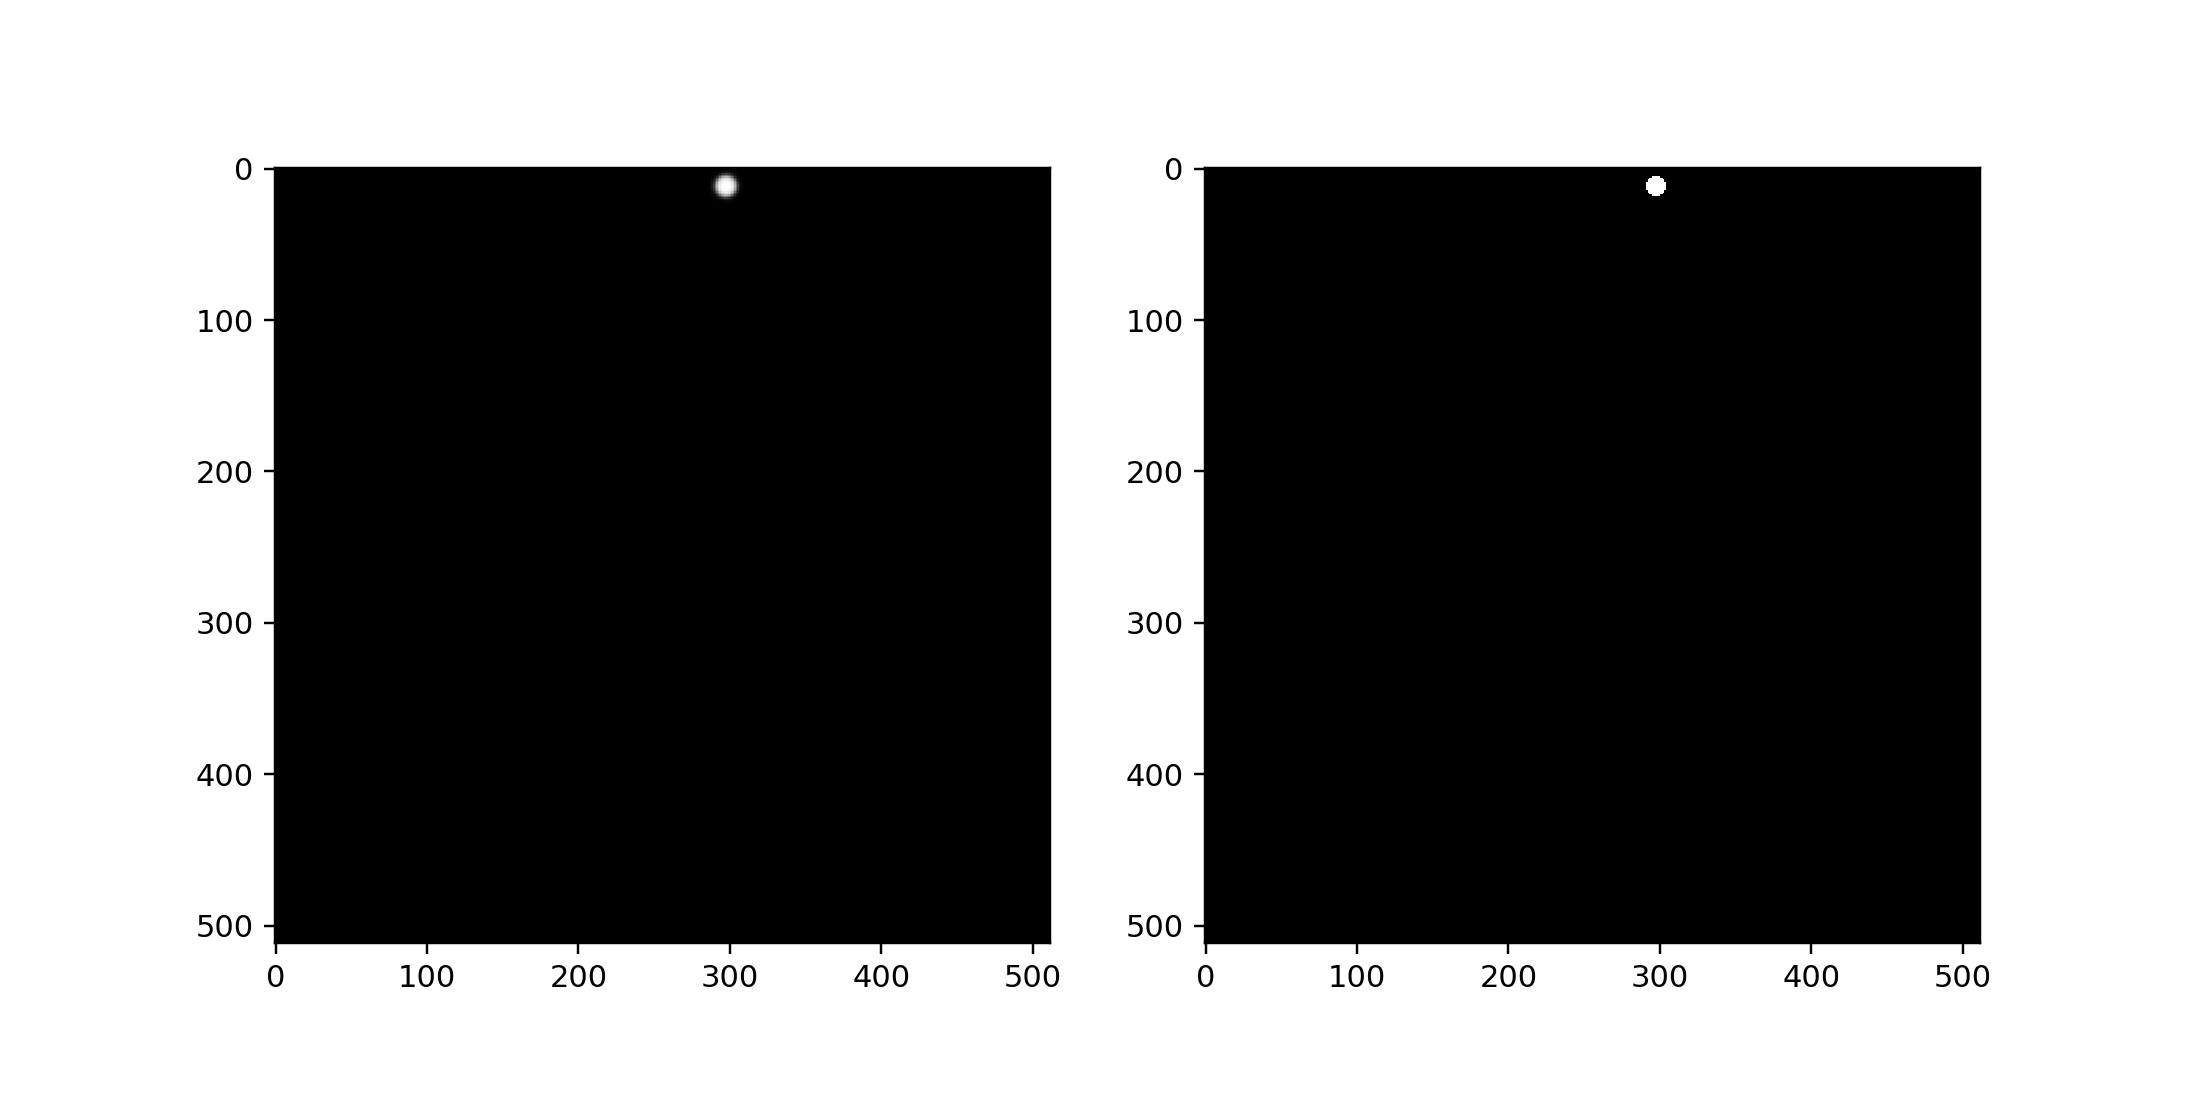

image 2


<IPython.core.display.Javascript object>


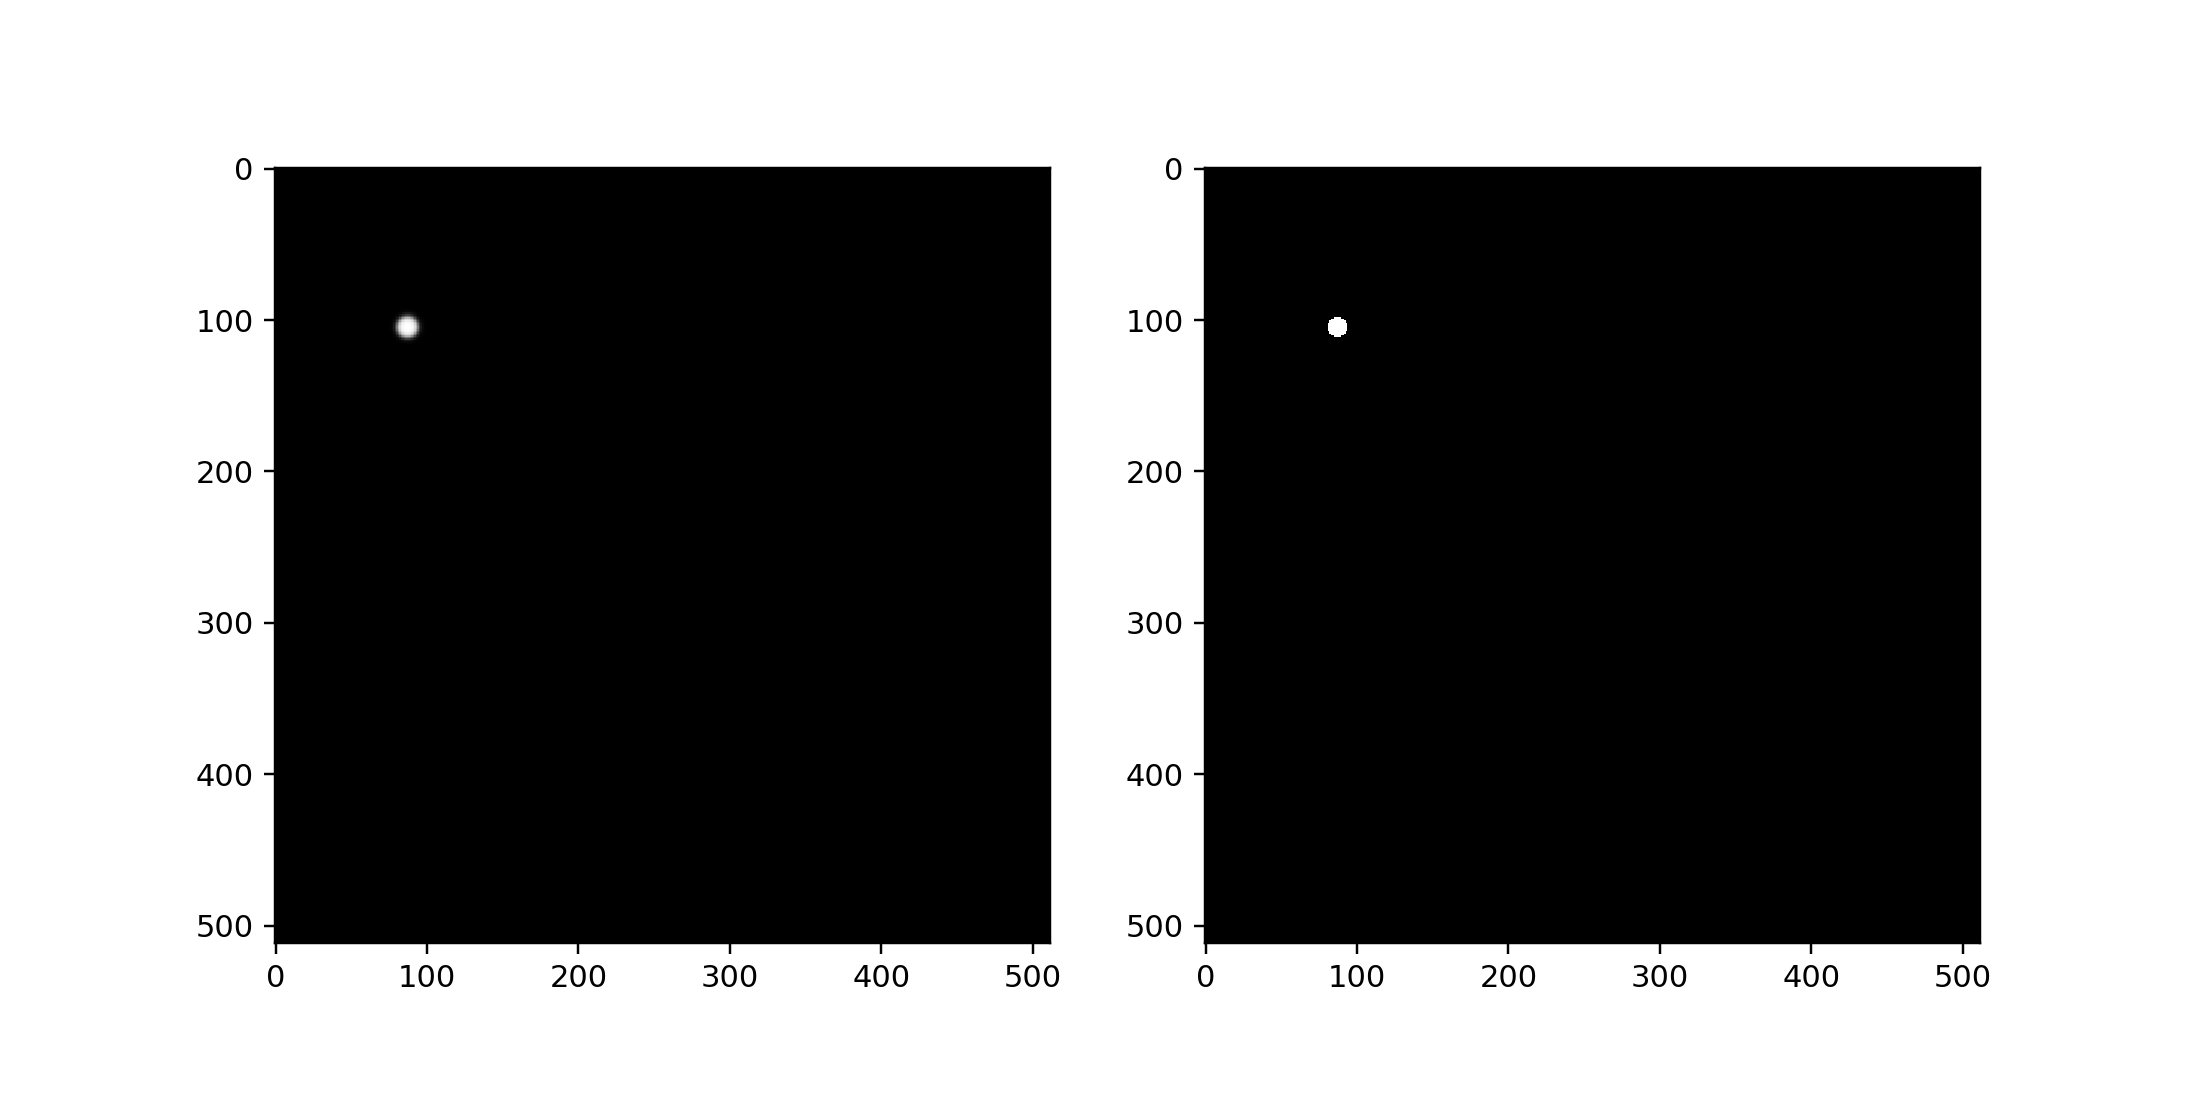

In [24]:
%matplotlib notebook

pred_masks = 'masksTestPredicted.npy'
label_masks = '../outs/fake_testMasks.npy'

masks = np.load(pred_masks)
l_masks = np.load(label_masks)

for i in range(3):
    print ("image %d" % i)
    
    fig,ax = plt.subplots(1,2,figsize=[10,5])
    
    ax[0].imshow(masks[i,0],cmap='gray') #mascara nodulo annotations.csv correspondente
    ax[1].imshow(l_masks[i,0],cmap='gray') #mascara nodulo annotations.csv correspondente

    
    plt.show()